# Initialize Code

In [1]:
import time
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from data_processor import  DataLoader, DataProcessor
from geometric_functions import GeometricDataTransformer
from loss_functions import ClassBalancedLoss
from visualisations import Visualiser
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_dense_batch
import importlib
from torch_geometric.explain import Explainer
from torch_geometric.explain.algorithm import GNNExplainer
import seaborn as sns

## Citiy Objects
Run this code. Add a dot in the Amsterdam object down below to see the different Dataframe options


In [5]:
Amsterdam = DataProcessor('Amsterdam')
Utrecht = DataProcessor('Utrecht')
TheHague = DataProcessor('The Hague')
Rotterdam = DataProcessor("Rotterdam")

In [6]:
Amsterdam

## Important for Paper
The code below was used to mke tables for in the paper


In [11]:
a = Amsterdam.crash_data.iloc[:5, :7]

b = a.to_latex(header=True, column_format='|c|c|c|c|c|c|c|c|c|')
print(b)

\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\toprule
 & NWB_ID & Day & Hour & Daytime & Night_time & Day_night_fct_ & Crash_freq \\
\midrule
0 & 1 & 1 & 0 & 0 & 1 & Night_time & 0 \\
1 & 1 & 1 & 1 & 0 & 1 & Night_time & 0 \\
2 & 1 & 1 & 2 & 0 & 1 & Night_time & 0 \\
3 & 1 & 1 & 3 & 0 & 1 & Night_time & 0 \\
4 & 1 & 1 & 4 & 0 & 1 & Night_time & 0 \\
\bottomrule
\end{tabular}



In [12]:
testje = Amsterdam.adjacency_data.loc[Amsterdam.adjacency_data['NWB_ID']==16298]
latex_table = testje.to_latex(index=False, escape=False)  # Convert to LaTeX
print(testje)

      NWB_ID                                             adj_ID
2596   16298  16293,16297,16300,16396,16397,16398,16399,1640...


In [15]:
crash_data = Amsterdam.crash_data
injuries = []
fatalities = []
other = []
for i in range(len(crash_data)):
    if crash_data['Crash_binary'][i] == 1:
        if crash_data['Crash_injury'][i]>0:
            injuries.append(crash_data['Crash_injury'][i])
        elif crash_data['Crash_fatal'][i]>0:
            fatalities.append(crash_data['Crash_fatal'][i])
        else:
            other.append(i)

In [16]:
crash_spatial = Amsterdam._create_spatial_df(data_df=Amsterdam.crash_data)

df = crash_spatial

# Step 1: Identify the municipality columns and speed variables
municipality_cols = ['AMS_mun', 'UTR_mun', 'ROT_mun', 'TH_mun']
speed_vars = ['Speed_50_separated', 'Speed_50_on_road', 'Speed_30_separated',  'Speed_30_on_road']

# Step 2: Create an empty DataFrame to hold the results
results = []

# Step 3: Loop through each speed variable to calculate totals and percentages for each municipality
for speed_var in speed_vars:
    # Create a dictionary to store the results for each municipality
    row = {'Speed_variable': speed_var}
    # Loop through each municipality column
    for mun_col in municipality_cols:
        # Filter the data where the municipality column is 1 (streets belonging to this municipality)
        mun_df = df[df[mun_col] == 1]
        total = len(mun_df[mun_df['Speed_infra_fct__']==speed_var])
        print(total, len(mun_df))
        percentage = (total / len(mun_df)) * 100 if len(mun_df) > 0 else 0

        # Store the result in the dictionary
        row[mun_col] = total
        row[f'{mun_col}_Percentage'] = percentage

    # Append the row to the results list
    results.append(row)

# Step 4: Convert the results into a DataFrame
final_result = pd.DataFrame(results)

# Step 5: Add a "Total" row that sums the 'Number' and 'Percentage' across all municipalities
total_row = {'Speed_variable': 'Total'}

# Summing the 'Number' and 'Percentage' columns for all municipalities
for mun_col in municipality_cols:
    total_row[mun_col] = final_result[mun_col].sum()
    total_row[f'{mun_col}_Percentage'] = final_result[f'{mun_col}_Percentage'].sum()

# Append the "Total" row to the final result
final_result = pd.concat([final_result, pd.DataFrame([total_row])], ignore_index=True)

# Display the result
print(final_result)

1622 2182
1152 1928
2080 4269
3388 9858
289 2182
246 1928
590 4269
1422 9858
41 2182
145 1928
366 4269
393 9858
230 2182
385 1928
1233 4269
4655 9858
       Speed_variable  AMS_mun  AMS_mun_Percentage  UTR_mun  \
0  Speed_50_separated     1622           74.335472     1152   
1    Speed_50_on_road      289           13.244730      246   
2  Speed_30_separated       41            1.879010      145   
3    Speed_30_on_road      230           10.540788      385   
4               Total     2182          100.000000     1928   

   UTR_mun_Percentage  ROT_mun  ROT_mun_Percentage  TH_mun  TH_mun_Percentage  
0           59.751037     2080           48.723354    3388          34.368026  
1           12.759336      590           13.820567    1422          14.424833  
2            7.520747      366            8.573436     393           3.986610  
3           19.968880     1233           28.882642    4655          47.220532  
4          100.000000     4269          100.000000    9858         100.

In [17]:
latex_table = final_result.to_latex(index=False, float_format="%.2f", caption="Crash Risk by Speed Variable and Municipality", label="tab:crash_risk")
print(latex_table)

\begin{table}
\caption{Crash Risk by Speed Variable and Municipality}
\label{tab:crash_risk}
\begin{tabular}{lrrrrrrrr}
\toprule
Speed_variable & AMS_mun & AMS_mun_Percentage & UTR_mun & UTR_mun_Percentage & ROT_mun & ROT_mun_Percentage & TH_mun & TH_mun_Percentage \\
\midrule
Speed_50_separated & 1622 & 74.34 & 1152 & 59.75 & 2080 & 48.72 & 3388 & 34.37 \\
Speed_50_on_road & 289 & 13.24 & 246 & 12.76 & 590 & 13.82 & 1422 & 14.42 \\
Speed_30_separated & 41 & 1.88 & 145 & 7.52 & 366 & 8.57 & 393 & 3.99 \\
Speed_30_on_road & 230 & 10.54 & 385 & 19.97 & 1233 & 28.88 & 4655 & 47.22 \\
Total & 2182 & 100.00 & 1928 & 100.00 & 4269 & 100.00 & 9858 & 100.00 \\
\bottomrule
\end{tabular}
\end{table}



In [18]:
import pandas as pd

# Step 1: Identify the municipality columns and speed variables
municipality_cols = ['AMS_mun', 'UTR_mun', 'ROT_mun', 'TH_mun']
vars150 = ['Offices_150', 'Commercial_150', 'Railway_150', 'Educ_150']

# Step 2: Create a list to store the results
results = []

# Step 3: Loop through each speed variable to calculate totals and percentages for each municipality
for speed_var in vars150:
    # Create the main row (Percentage)
    percentage_row = {'Speed_variable': speed_var}
    # Create the 'Other' row for complements
    other_row = {'Speed_variable': f"{speed_var}_Other"}

    # Loop through each municipality column
    for mun_col in municipality_cols:
        # Filter the data where the municipality column is 1
        mun_df = df[df[mun_col] == 1]
        total_streets = len(mun_df)  # Total streets in this municipality
        number = len(mun_df[mun_df[speed_var] == 1])  # Streets matching the condition
        percentage = (number / total_streets) * 100 if total_streets > 0 else 0
        other_number = total_streets - number  # Complement count
        other_percentage = 100 - percentage  # Complement percentage

        # Fill the rows for the municipality
        percentage_row[f"{mun_col}_Number"] = number
        percentage_row[f"{mun_col}_Percentage"] = percentage
        other_row[f"{mun_col}_Number"] = other_number
        other_row[f"{mun_col}_Percentage"] = other_percentage

    # Append the rows to the results list
    results.append(percentage_row)
    results.append(other_row)

# Step 4: Convert the results into a DataFrame
final_result = pd.DataFrame(results)

# Display the final DataFrame
print(final_result)


         Speed_variable  AMS_mun_Number  AMS_mun_Percentage  UTR_mun_Number  \
0           Offices_150             335           15.352887             526   
1     Offices_150_Other            1847           84.647113            1402   
2        Commercial_150            1042           47.754354             600   
3  Commercial_150_Other            1140           52.245646            1328   
4           Railway_150              24            1.099908              64   
5     Railway_150_Other            2158           98.900092            1864   
6              Educ_150             459           21.035747             432   
7        Educ_150_Other            1723           78.964253            1496   

   UTR_mun_Percentage  ROT_mun_Number  ROT_mun_Percentage  TH_mun_Number  \
0           27.282158             629           14.734130           1154   
1           72.717842            3640           85.265870           8704   
2           31.120332            1664           38.978684   

In [19]:
latex_table = final_result.to_latex(index=False, float_format="%.2f", caption="Crash Risk by Speed Variable and Municipality", label="tab:crash_risk")
print(latex_table)

\begin{table}
\caption{Crash Risk by Speed Variable and Municipality}
\label{tab:crash_risk}
\begin{tabular}{lrrrrrrrr}
\toprule
Speed_variable & AMS_mun_Number & AMS_mun_Percentage & UTR_mun_Number & UTR_mun_Percentage & ROT_mun_Number & ROT_mun_Percentage & TH_mun_Number & TH_mun_Percentage \\
\midrule
Offices_150 & 335 & 15.35 & 526 & 27.28 & 629 & 14.73 & 1154 & 11.71 \\
Offices_150_Other & 1847 & 84.65 & 1402 & 72.72 & 3640 & 85.27 & 8704 & 88.29 \\
Commercial_150 & 1042 & 47.75 & 600 & 31.12 & 1664 & 38.98 & 3132 & 31.77 \\
Commercial_150_Other & 1140 & 52.25 & 1328 & 68.88 & 2605 & 61.02 & 6726 & 68.23 \\
Railway_150 & 24 & 1.10 & 64 & 3.32 & 78 & 1.83 & 71 & 0.72 \\
Railway_150_Other & 2158 & 98.90 & 1864 & 96.68 & 4191 & 98.17 & 9787 & 99.28 \\
Educ_150 & 459 & 21.04 & 432 & 22.41 & 1235 & 28.93 & 1633 & 16.57 \\
Educ_150_Other & 1723 & 78.96 & 1496 & 77.59 & 3034 & 71.07 & 8225 & 83.43 \\
\bottomrule
\end{tabular}
\end{table}



In [20]:
a = Amsterdam._create_spatial_df( Amsterdam.integer_df)
b = a['Crash_freq'].value_counts()
c = b.to_latex()
print(c)

\begin{tabular}{lr}
\toprule
 & count \\
Crash_freq &  \\
\midrule
0 & 1550 \\
1 & 340 \\
2 & 143 \\
3 & 57 \\
4 & 43 \\
5 & 24 \\
6 & 11 \\
8 & 6 \\
7 & 3 \\
9 & 3 \\
12 & 1 \\
13 & 1 \\
\bottomrule
\end{tabular}



In [21]:
a = TheHague._create_spatial_df( TheHague.integer_df)
b = a['Crash_freq'].value_counts()
c = b.to_latex()
print(c)

\begin{tabular}{lr}
\toprule
 & count \\
Crash_freq &  \\
\midrule
0 & 8606 \\
1 & 964 \\
2 & 191 \\
3 & 60 \\
4 & 22 \\
5 & 8 \\
6 & 4 \\
8 & 2 \\
7 & 1 \\
\bottomrule
\end{tabular}



In [31]:
import pandas as pd

# Step 1: Define the data from the LaTeX table as a dictionary
data = {
    'Crash Frequency': ['1 crash', '2 crashes', '3 crashes', 'Crashes Total', '0 crashes', 'Total'],
    'Amsterdam': [1258, 9, 0, 1267, 365309, 366576],
    'Utrecht': [511, 5, 0, 516, 323388, 323904],
    'Rotterdam': [1148, 8, 1, 1157, 716035, 717192],
    'The Hague': [1681, 10, 0, 1691, 1654453, 1656144],
    'Total': [4598, 32, 1, 4631, 3059185, 3063816]
}

# Step 2: Create a DataFrame
df = pd.DataFrame(data)

# Step 3: Calculate percentages, excluding 'Total' column
for column in df.columns[1:-1]:  # Exclude 'Crash Frequency' and 'Total' columns
    if column != 'Total':  # Ensure 'Total' column is skipped
        df[column + ' (%)'] = (df[column] / df[column].iloc[1:5].sum()) * 100
# Step 4: Append the percentage in brackets after the original numbers
for column in df.columns[1:-1]:  # Exclude 'Crash Frequency' and 'Total' columns
    if column + ' (%)' in df:  # Ensure the percentage column exists
        df[column] = df[column].astype(str) + " (" + df[column + ' (%)'].round(2).astype(str) + "%)"

# Step 5: Drop the 'Total' column and its percentage column before LaTeX conversion
df = df.drop(columns=['Total'], errors='ignore')
df = df.drop(columns=['Total (%)'], errors='ignore')  # Prevent KeyError

# Step 6: Convert the DataFrame to LaTeX format
latex_table = df.to_latex(index=False, escape=False)

# Print the LaTeX code for the updated table
print(latex_table)


\begin{tabular}{lllllrrrr}
\toprule
Crash Frequency & Amsterdam & Utrecht & Rotterdam & The Hague & Amsterdam (%) & Utrecht (%) & Rotterdam (%) & The Hague (%) \\
\midrule
1 crash & 1258 (0.34%) & 511 (0.16%) & 1148 (0.16%) & 1681 (0.1%) & 0.343167 & 0.157760 & 0.160067 & 0.101500 \\
2 crashes & 9 (0.0%) & 5 (0.0%) & 8 (0.0%) & 10 (0.0%) & 0.002455 & 0.001544 & 0.001115 & 0.000604 \\
3 crashes & 0 (0.0%) & 0 (0.0%) & 1 (0.0%) & 0 (0.0%) & 0.000000 & 0.000000 & 0.000139 & 0.000000 \\
Crashes Total & 1267 (0.35%) & 516 (0.16%) & 1157 (0.16%) & 1691 (0.1%) & 0.345622 & 0.159304 & 0.161322 & 0.102104 \\
0 crashes & 365309 (99.65%) & 323388 (99.84%) & 716035 (99.84%) & 1654453 (99.9%) & 99.651922 & 99.839152 & 99.837424 & 99.897292 \\
Total & 366576 (100.0%) & 323904 (100.0%) & 717192 (100.0%) & 1656144 (100.0%) & 99.997545 & 99.998456 & 99.998745 & 99.999396 \\
\bottomrule
\end{tabular}



# Set Up for Results

## Setting up data objects

In [32]:
columns_to_drop_crash_binary = ['Crash_freq', 'Crash_fatal', 'Crash_injury', 'Bic_exp_log', 'MV_exp_log', 'length_km', 'UTR_mun', 'AMS_mun', 'ROT_mun', 'TH_mun']
columns_to_drop_crash_injury = ['Crash_freq', 'Crash_fatal', 'Crash_binary', 'Bic_exp_log', 'MV_exp_log', 'length_km', 'UTR_mun', 'AMS_mun', 'ROT_mun', 'TH_mun']
columns_to_drop_crash_fatal = ['Crash_freq', 'Crash_binary', 'Crash_injury', 'Bic_exp_log', 'MV_exp_log', 'length_km', 'UTR_mun', 'AMS_mun', 'ROT_mun', 'TH_mun']

Amsterdam_Data = GeometricDataTransformer(Amsterdam, Amsterdam.binary_df)
Utrecht_Data = GeometricDataTransformer(Utrecht, Utrecht.binary_df)
Rotterdam_Data = GeometricDataTransformer(Rotterdam, Rotterdam.binary_df)
TheHague_Data = GeometricDataTransformer(TheHague, TheHague.binary_df)


Amsterdam_Data_crash_binary = Amsterdam_Data.create_data_object(drop_columns=columns_to_drop_crash_binary)
Utrecht_Data_crash_binary  = Utrecht_Data.create_data_object(drop_columns=columns_to_drop_crash_binary)
Rotterdam_Data_crash_binary  = Rotterdam_Data.create_data_object(drop_columns=columns_to_drop_crash_binary)
TheHague_Data_crash_binary  = TheHague_Data.create_data_object(drop_columns=columns_to_drop_crash_binary)
Amsterdam_Data_crash_injury= Amsterdam_Data.create_data_object(drop_columns=columns_to_drop_crash_injury, target_column='Crash_injury')
Utrecht_Data_crash_injury = Utrecht_Data.create_data_object(drop_columns=columns_to_drop_crash_injury, target_column='Crash_injury')
Rotterdam_Data_crash_injury  = Rotterdam_Data.create_data_object(drop_columns=columns_to_drop_crash_injury, target_column='Crash_injury')
TheHague_Data_crash_injury  = TheHague_Data.create_data_object(drop_columns=columns_to_drop_crash_injury, target_column='Crash_injury')

Amsterdam_Data_crash_fatal= Amsterdam_Data.create_data_object(drop_columns=columns_to_drop_crash_fatal, target_column='Crash_fatal')
Utrecht_Data_crash_fatal = Utrecht_Data.create_data_object(drop_columns=columns_to_drop_crash_fatal, target_column='Crash_fatal')
Rotterdam_Data_crash_fatal  = Rotterdam_Data.create_data_object(drop_columns=columns_to_drop_crash_fatal, target_column='Crash_fatal')
TheHague_Data_crash_fatal  = TheHague_Data.create_data_object(drop_columns=columns_to_drop_crash_fatal, target_column='Crash_fatal')


The data has to be made undirected
10 percent done
20 percent done
30 percent done
40 percent done
50 percent done
60 percent done
70 percent done
80 percent done
90 percent done
100 percent done
The data has to be made undirected
10 percent done
20 percent done
30 percent done
40 percent done
50 percent done
60 percent done
70 percent done
80 percent done
90 percent done
100 percent done
The data has to be made undirected
10 percent done
20 percent done
30 percent done
40 percent done
50 percent done
60 percent done
70 percent done
80 percent done
90 percent done
100 percent done
The data has to be made undirected
10 percent done
20 percent done
30 percent done
40 percent done
50 percent done
60 percent done
70 percent done
80 percent done
90 percent done
100 percent done


In [35]:
# Flattened list of all data objects
all_data_objects = [
    Amsterdam_Data_crash_binary, Utrecht_Data_crash_binary, Rotterdam_Data_crash_binary, TheHague_Data_crash_binary,
    Amsterdam_Data_crash_injury, Utrecht_Data_crash_injury, Rotterdam_Data_crash_injury, TheHague_Data_crash_injury,
    Amsterdam_Data_crash_fatal, Utrecht_Data_crash_fatal, Rotterdam_Data_crash_fatal, TheHague_Data_crash_fatal,
]
string_names = [
    "Amsterdam_Data_crash_binary", "Utrecht_Data_crash_binary", "Rotterdam_Data_crash_binary", "TheHague_Data_crash_binary",
    "Amsterdam_Data_crash_injury", "Utrecht_Data_crash_injury", "Rotterdam_Data_crash_injury", "TheHague_Data_crash_injury",
    "Amsterdam_Data_crash_fatal", "Utrecht_Data_crash_fatal", "Rotterdam_Data_crash_fatal", "TheHague_Data_crash_fatal"
]

In [36]:
Amsterdam_Data_crash_binary.data_object_PyG

Data(x=[2182, 15], edge_index=[2, 9892], y=[2182], num_classes=2)

## Traing the models
The code below trains the models. Due to everything needing to be contained and easily accessible it also creates plots
Since all the information is alsow in 'newtrainersdictionary.pth', just use that

In [37]:
from models import Trainer, GCNModel, MLPModel
data_list = all_data_objects[:4]
hidden_channels_list = [15, 15]
num_epochs = 500
the_dict = {}
"""
for index, data in enumerate(data_list):
    print("GCN with BCELoss for " + data.city_name)
    model = GCNModel(data_obj=data, hidden_channels_list=hidden_channels_list)
    target = data.data_object_PyG.y.view(-1, 1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #, weight_decay=5e-4) # adam optimizer
    criterion =  torch.nn.BCELoss(weight=torch.tensor(100))
    trainer = Trainer(model=model, city_data = data, criterion=criterion, optimizer=optimizer, n_epochs=num_epochs)

    print("MLP with BCELoss for " + data.city_name)
    model2 = MLPModel(data_obj=data, hidden_channels_list=hidden_channels_list)
    optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)# , weight_decay=5e-4) # adam optimizer
    trainer2 = Trainer(model=model2, city_data = data, criterion=criterion, optimizer=optimizer, n_epochs=num_epochs)

    print("GCN with Class-BalancedLoss for " + data.city_name)
    model3 = GCNModel(data_obj=data, hidden_channels_list=hidden_channels_list)
    optimizer = torch.optim.Adam(model3.parameters(), lr=0.01) #, weight_decay=5e-4) # adam optimizer
    criterion = ClassBalancedLoss(torch.nn.BCELoss(weight=torch.tensor(100), reduction='none'), target) # Binary Cross Entropy
    trainer3 = Trainer(model=model, city_data = data, criterion=criterion, optimizer=optimizer, n_epochs=num_epochs)

    print("MLP with Class-BalancedLoss for " + data.city_name)
    model4 = MLPModel(data_obj=data, hidden_channels_list=hidden_channels_list)
    optimizer = torch.optim.Adam(model4.parameters(), lr=0.01)# , weight_decay=5e-4) # adam optimizer
    trainer4 = Trainer(model=model4, city_data = data, criterion=criterion, optimizer=optimizer, n_epochs=num_epochs)
    trainers_list = [trainer, trainer2, trainer3, trainer4]
    the_dict[string_names[index]] = trainers_list
"""

'\nfor index, data in enumerate(data_list):\n    print("GCN with BCELoss for " + data.city_name)\n    model = GCNModel(data_obj=data, hidden_channels_list=hidden_channels_list)\n    target = data.data_object_PyG.y.view(-1, 1)\n    optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #, weight_decay=5e-4) # adam optimizer\n    criterion =  torch.nn.BCELoss(weight=torch.tensor(100))\n    trainer = Trainer(model=model, city_data = data, criterion=criterion, optimizer=optimizer, n_epochs=num_epochs)\n\n    print("MLP with BCELoss for " + data.city_name)\n    model2 = MLPModel(data_obj=data, hidden_channels_list=hidden_channels_list)\n    optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)# , weight_decay=5e-4) # adam optimizer\n    trainer2 = Trainer(model=model2, city_data = data, criterion=criterion, optimizer=optimizer, n_epochs=num_epochs)\n\n    print("GCN with Class-BalancedLoss for " + data.city_name)\n    model3 = GCNModel(data_obj=data, hidden_channels_list=hidden_chan

## Setting up the different models

In [39]:
import torch
newtrainersdictionary = torch.load('newtrainersdictionary.pth')

C:\Users\woute\AppData\Local\Temp\ipykernel_16104\1014346610.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  newtrainersdictionary = torch.load('newtrainersdictionary.pt

In [43]:
AmsterdamGCN = newtrainersdictionary['Amsterdam_Data_crash_binary']['GCNModelBCELoss']

## Explainer Section

In [44]:
from GNN_Explainers_class import GNNExplainers
Explainer = GNNExplainers(AmsterdamGCN)


C:\Users\woute\PycharmProjects\ThesisTesting\GNN_Explainers_class.py:201: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os.path.exists(path_name) and not overwrite:


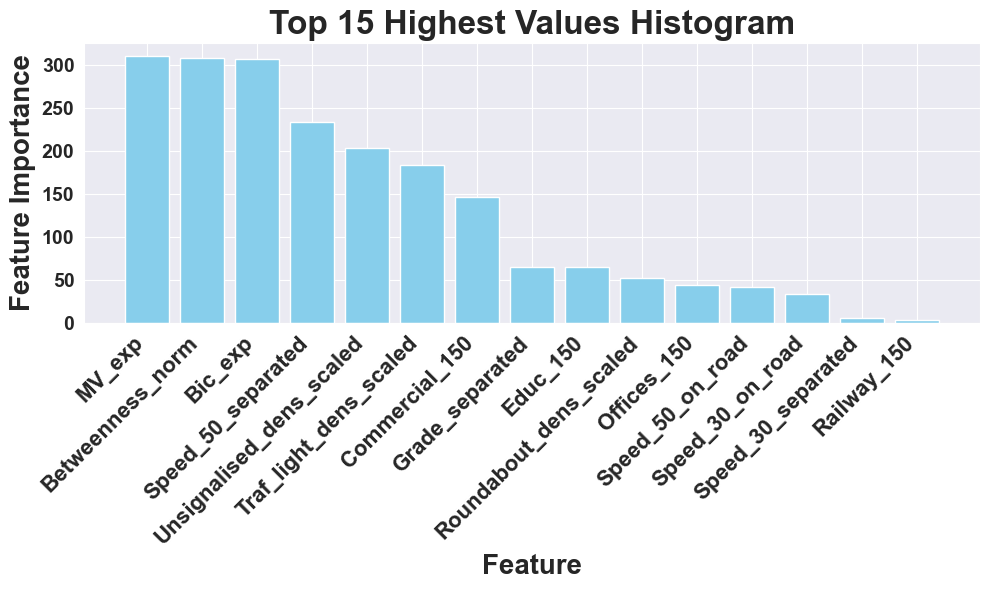

,Feature,BCELossAmsterdam
0,MV_exp,310.008881
1,Betweenness_norm,307.820862
2,Bic_exp,306.525970
3,Speed_50_separated,233.305161
4,Unsignalised_dens_scaled,202.995758
5,Traf_light_dens_scaled,183.550583
6,Commercial_150,146.010010
7,Grade_separated,64.527802
8,Educ_150,64.442627
9,Roundabout_dens_scaled,51.636200


In [46]:
Explainer.visualize_features()